### Imports

In [2]:
import warnings
import time
from simulai.metrics import L2Norm
import time
with warnings.catch_warnings():
    
    from scipy.integrate import odeint
    import matplotlib.pyplot as plt
    import numpy as np
    from torch.nn.functional import mse_loss

    from numpy import pi
    from scipy.fftpack import fft, ifft
    from simulai.regression import OpInf
    from simulai.math.integration import RK4, LSODA, FunctionWrapper, ClassWrapper
    from simulai.math.differentiation import CollocationDerivative
    from simulai.rom import POD
    from simulai.io import Reshaper
    from simulai.simulation import Pipeline
    


# Adjustment to numpy's error/warning handling for floating point operations

np.seterr(over='raise', invalid='raise');

In [ ]:
# Function for normal plot

def plot(data):
  plt.figure(figsize=(4, 8))
  n, s = np.meshgrid(np.arange(np.shape(data)[0]), np.arange(np.shape(data)[1])+1)
  plt.contourf(s, n, np.transpose(data), 15, cmap=plt.get_cmap("seismic"))
  plt.colorbar()
  plt.show()
  plt.close()

In [ ]:
# Function to compare plots

def compare_plot(data1, data2, text1="Sample 1", text2="Sample 2"):

  if data1.shape != data2.shape:
    print("Both data must have the same shape")
    print("Data1:", data1.shape)
    print("Data2:", data2.shape)
  else:

    fig, axs = plt.subplots(1, 2, sharey=True,  figsize=(7, 8))
    fig.tight_layout(pad=2.0)
    n, s = np.meshgrid(np.arange(np.shape(data1)[0]), np.arange(np.shape(data1)[1])+1)
    im0 = axs[0].contourf(s, n, np.transpose(data1), 15, cmap=plt.get_cmap("seismic"))
    plt.colorbar(im0)
    axs[0].set_title(text1)

    im1 = axs[1].contourf(s, n, np.transpose(data2), 15, cmap=plt.get_cmap("seismic"))
    plt.colorbar(im1)
    axs[1].set_title(text2)

    for ax in axs.flat:
        ax.set(xlabel='x', ylabel='t')

    plt.show()
    plt.close()

### Data

In [ ]:
with h5py.File(".\\dataset\\DeepONet\\unitData.h5", 'r') as f:
  d = list(f["solEvalPoints"])
  # IDs of nodes used as trunk network inputs
  nodeID = list(map(int, d[0]))
  # [x y t] of y points (trunk inputs).
  # matrix with rows [x y t]
  solEvalPoint = torch.tensor(np.concatenate([d[1][:, None], d[2][:, None], d[3][:, None]], axis = 1))
  # DeepONet output targets (G(u)(y)) for all initial conditions
  # matrix with 'initial condition' rows and 'y point' columns
  solutionValue = torch.tensor(f["solutionValues"]).T

# POD (Proper Orthogonal Decomposition)

We reduced the dimentions from $ 512 $ to $ 100$ using the method POD (Proper Orthogonal Decomposition).


In [ ]:
# Instantiating a Pipeline object in order to execute a reshaping and a POD projection in the data
n_components = 100

rom_config = {
               'n_components': n_components
              }
# Instantiating the class Pipeline
pipeline = Pipeline(stages=[('data_preparer', Reshaper()),
                            ('rom', POD(config=rom_config))])

# Executing the workflow shown in the list stages
pipeline.exec(input_data=u)

projected_data = pipeline.project_data(data=u)
reconstructed_data = pipeline.reconstruct_data(data=projected_data)


Executing a global pipeline.
Executed operation RESHAPER.
Relative contribution of the mean component: 0.0004033252480439842
Relative Modal Energy 0.9922794596207345
Executed operation POD.
Applying the global reconstruction strategy.


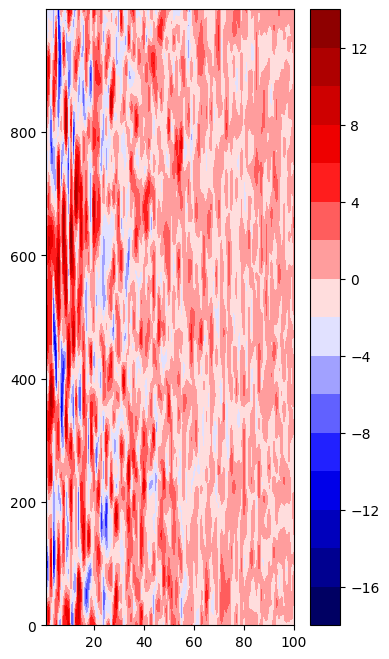

In [ ]:
plot(projected_data[0:1000])

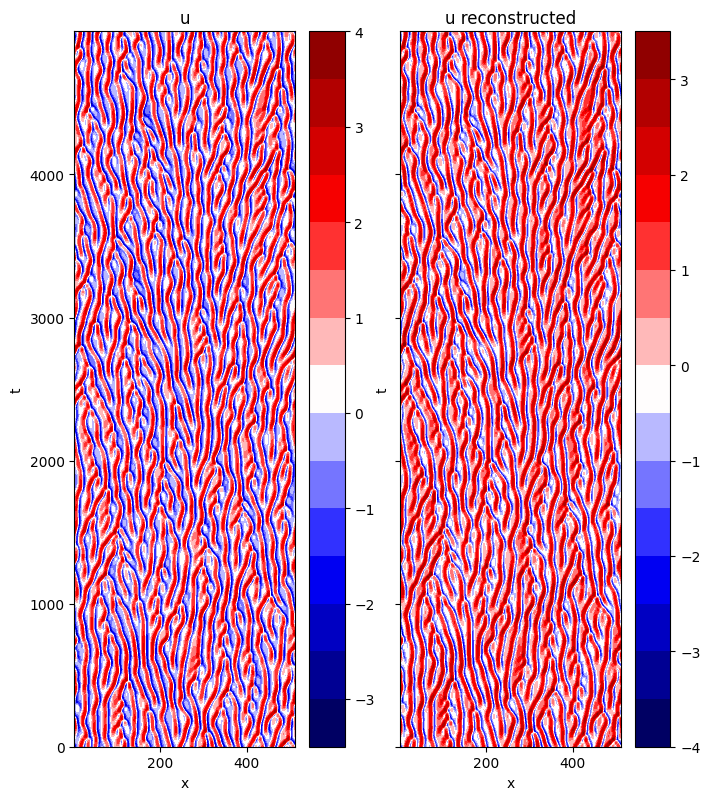

In [ ]:
# Comparing the reconstruction
compare_plot(u[0:5000], reconstructed_data[0:5000], "u", "u reconstructed")

# OpInf

As described in [3] OpInf is "a new scientific machine learning method that learns from data a computationally inexpensive surrogate model for predicting the evolution of a system governed by a time-dependent nonlinear partial differential equation (PDE), an enabling technology for many computational algorithms used in engineering settings".

Trying to obtain the best model, we executed a grid search for the best parameters. For this process, we splited the data between train ($90\%$) and test ($10\%$).

In [ ]:
# Let's define train and test dataset. 
# The train will be 90% of the samples and the test will be
# the 10% left.

start = 0
end = 150000
n_split = 135000 # (0.9 * 150000)

In [ ]:
KS_data = projected_data[start:end]
diff = CollocationDerivative(config={})
KS_derivative_data = diff.solve(data=KS_data,x=t[start:end])
t_data = t[start:end]

KS_data_train = KS_data[:n_split]
KS_data_test = KS_data[n_split:]


KS_derivative_data_train = KS_derivative_data[:n_split]
KS_derivative_data_test = KS_derivative_data[n_split:]

t_data_train = t_data[:n_split]
t_data_test = t_data[n_split:]

Performing Collocation Derivation.


In [ ]:
print("KS_data: ",  KS_data.shape)
print("KS_derivative_data: ", KS_derivative_data.shape)
print("t_data: ", t_data.shape)

print("KS_data_train: ", KS_data_train.shape)
print("KS_data_test: ", KS_data_test.shape)


print("KS_derivative_data_train: ", KS_derivative_data_train.shape)
print("KS_derivative_data_test: ", KS_derivative_data_test.shape)

print("t_data_train: ", t_data_train.shape)
print("t_data_train begins in t: ", t_data_train[0] )
print("t_data_train ends in t: ", t_data_train[-1] )

print("t_data_test: ", t_data_test.shape)
print("t_data_test begins in t: ", t_data_test[0] )
print("t_data_test ends in t: ", t_data_test[-1] )


KS_data:  (150000, 100)
KS_derivative_data:  (150000, 100)
t_data:  (150000,)
KS_data_train:  (135000, 100)
KS_data_test:  (15000, 100)
KS_derivative_data_train:  (135000, 100)
KS_derivative_data_test:  (15000, 100)
t_data_train:  (135000,)
t_data_train begins in t:  1250.0
t_data_train ends in t:  18124.875
t_data_test:  (15000,)
t_data_test begins in t:  18125.0
t_data_test ends in t:  19999.875


## Regularization

Trying to avoid overfitting, we executed a grid search looking for the best parameters of the model that fits unseen data (test dataset).

This section was kept in the code to explain, in a didactic way, how the best regularizers were chosen. It can be skipped without affecting the understanding of the solution.

In [ ]:
# Grid Search

grid_x = []
grid_y = []
error_list = []

lambda_linear_list = [1e+3, 1e+2, 1e+1,  1e+0, 1e-1, 1e-2,  1e-3]
lambda_quadratic_list = [1e+3, 1e+2, 1e+1,  1e+0, 1e-1, 1e-2,  1e-3]
parallel = None
t_test = t_data_test[0:200] # Testing only the first 200 samples

for lambda_linear in lambda_linear_list:
  for lambda_quadratic in lambda_quadratic_list:
    initial_time = time.time()
    print("lambda_linear: ", lambda_linear)
    print("lambda_quadratic: ", lambda_quadratic)    
    KS_op = OpInf(bias_rescale=1e-15, solver='lstsq', parallel=parallel)
    KS_op.set(lambda_linear=lambda_linear, lambda_quadratic=lambda_quadratic)
    KS_op.fit(input_data=KS_data_train, target_data=KS_derivative_data_train)
    KS_op.construct_K_op()
    right_operator = ClassWrapper(KS_op)
    solver = LSODA(right_operator)
    estimated_field = solver.run(KS_data_train[-1], t_test)
    elapsed_time = time.time() - initial_time
    print(f"Elapsed time: {elapsed_time} s")
    error =RMSE(estimated_field, KS_data_test[0:200])
    print("Erro RMSE test:", error)
    print("-----")
    grid_x.append(lambda_linear)
    grid_y.append(lambda_quadratic)
    error_list.append(error) 



lambda_linear:  1000.0
lambda_quadratic:  1000.0
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 174.38062000274658 s
Erro RMSE test: 5.787953765285677
-----
lambda_linear:  1000.0
lambda_quadratic:  100.0
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Elapsed time: 160.29115056991577 s
Erro RMSE test: 86113.30082490362
-----
lambda_linear:  1000.0
lambda_quadratic:  10.0
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 157.75361013412476 s
Erro RMSE test: 18187.903333948867
-----
lambda_linear:  1000.0
lambda_quadratic:  1.0
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 156.39175868034363 s
Erro RMSE test: 89456.45663665069
-----
lambda_linear:  1000.0
lambda_quadratic:  0.1
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 163.36243152618408 s
Erro RMSE test: 55076.983389840134
-----
lambda_linear:  1000.0
lambda_quadratic:  0.01
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 161.4426908493042 s
Erro RMSE test: 89921.76131403793
-----
lambda_linear:  1000.0
lambda_quadratic:  0.001
Forcing terms are not being used.
Solving 

In [ ]:
error_list2 = error_list.copy()
error_list2 = np.array(error_list2)

# Taking the min index
min = np.argmin(error_list2)

print("The best parameters are:")
print("Lambda linear:", grid_x[min])
print("Lambda quadratic:", grid_y[min])

The best parameters are:
Lambda linear: 0.001
Lambda quadratic: 100.0


In [ ]:
# Fine tunning
# Grid Search

grid_x = []
grid_y = []
error_list = []

lambda_linear_list = [0.001]
lambda_quadratic_list = [50, 100, 250, 500, 750]
parallel = None
t_test = t_data_test[0:200] # Testing only the first 200 samples

for lambda_linear in lambda_linear_list:
  for lambda_quadratic in lambda_quadratic_list:
    initial_time = time.time()
    print("lambda_linear: ", lambda_linear)
    print("lambda_quadratic: ", lambda_quadratic)    
    KS_op = OpInf(bias_rescale=1e-15, solver='lstsq', parallel=parallel)
    KS_op.set(lambda_linear=lambda_linear, lambda_quadratic=lambda_quadratic)
    KS_op.fit(input_data=KS_data_train, target_data=KS_derivative_data_train)
    KS_op.construct_K_op()
    right_operator = ClassWrapper(KS_op)
    solver = LSODA(right_operator)
    estimated_field = solver.run(KS_data_train[-1], t_test)
    elapsed_time = time.time() - initial_time
    print(f"Elapsed time: {elapsed_time} s")
    error =RMSE(estimated_field, KS_data_test[0:200])
    print("Erro RMSE test:", error)
    print("-----")
    grid_x.append(lambda_linear)
    grid_y.append(lambda_quadratic)
    error_list.append(error) 



lambda_linear:  0.001
lambda_quadratic:  50
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 165.54569816589355 s
Erro RMSE test: 2.9896345411311525
-----
lambda_linear:  0.001
lambda_quadratic:  100
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 163.5212597846985 s
Erro RMSE test: 2.8406338082348372
-----
lambda_linear:  0.001
lambda_quadratic:  250
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 161.96579670906067 s
Erro RMSE test: 2.727284126525655
-----
lambda_linear:  0.001
lambda_quadratic:  500
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 162.50048232078552 s
Erro RMSE test: 3.316997002431069
-----
lambda_linear:  0.001
lambda_quadratic:  750
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Elapsed time: 188.23635935783386 s
Erro 

In [ ]:
error_list3 = error_list.copy()
error_list3 = np.array(error_list3)

# Taking the min index
min = np.argmin(error_list3)

print("The best parameters are:")
print("Lambda linear:", grid_x[min])
print("Lambda quadratic:", grid_y[min])

The best parameters are:
Lambda linear: 0.001
Lambda quadratic: 250


## Using the best parameters

Once defined the best parameters, we executed again the OpInf using this parameters.

In [ ]:
lambda_linear= 0.001
lambda_quadratic = 250

initial_time = time.time()
print("lambda_linear: ", lambda_linear)
print("lambda_quadratic: ", lambda_quadratic)    
KS_op = OpInf(bias_rescale=1e-15, solver='lstsq', parallel=parallel)
KS_op.set(lambda_linear=lambda_linear, lambda_quadratic=lambda_quadratic)
KS_op.fit(input_data=KS_data_train, target_data=KS_derivative_data_train)
KS_op.construct_K_op()
right_operator = ClassWrapper(KS_op)
solver = LSODA(right_operator)
estimated_field = solver.run(KS_data_train[0], t_data_train[0:200])
error =RMSE(estimated_field, KS_data_train[0:200])
print("Erro RMSE train:", error)

estimated_field = solver.run(KS_data_train[-1], t_data_test[0:200])
error =RMSE(estimated_field, KS_data_test[0:200])
print("Erro RMSE test:", error)

elapsed_time = time.time() - initial_time
print(f"Elapsed time: {elapsed_time} s")
print("-----") 

lambda_linear:  0.001
lambda_quadratic:  250
Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.
Erro RMSE train: 2.367253705900636
Erro RMSE test: 2.727284126525655
Elapsed time: 164.94832730293274 s
-----


In [ ]:
print(f"A_hat: {np.array_str(KS_op.A_hat, precision=5, suppress_small=True)}")
print(f"H_hat: {np.array_str(KS_op.H_hat, precision=5, suppress_small=True)}")
print(f"c_hat: {np.array_str(KS_op.c_hat, precision=5, suppress_small=True)}")

A_hat: [[ 0.16617  0.00341  0.00105 ... -0.00025  0.01357  0.02252]
 [ 0.00065  0.1696  -0.00369 ...  0.00719 -0.00956  0.0012 ]
 [ 0.00207  0.00038  0.16687 ... -0.02012 -0.01456 -0.036  ]
 ...
 [-0.00023 -0.00346 -0.00264 ... -1.57028  0.03019  0.08512]
 [-0.00164 -0.00371  0.00354 ...  0.01149 -1.49386  0.04554]
 [ 0.00381  0.00605  0.00004 ...  0.03663 -0.01732 -1.49321]]
H_hat: [[-0.00012 -0.00025  0.00009 ...  0.00045  0.0008  -0.00037]
 [ 0.00042  0.00026  0.00016 ... -0.00054  0.00043 -0.00025]
 [-0.00009  0.00023 -0.00018 ... -0.00098 -0.00065 -0.00106]
 ...
 [-0.00058  0.00079 -0.00152 ... -0.00019  0.00152 -0.00177]
 [-0.00002  0.00023 -0.00155 ... -0.00086 -0.00116  0.00087]
 [-0.00086  0.00071  0.00055 ... -0.00263 -0.00024 -0.00184]]
c_hat: [[ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]
 [ 0.]
 [-0

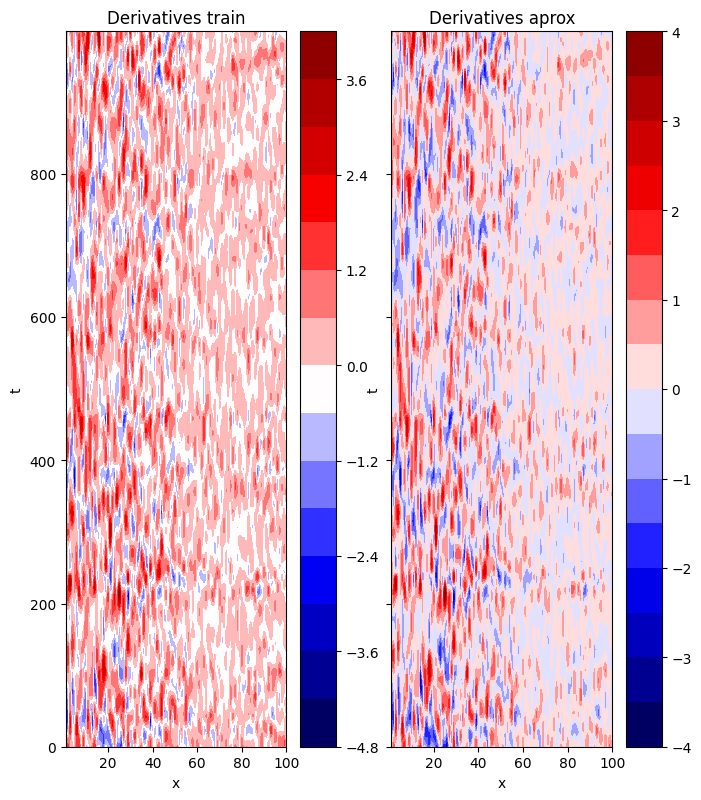

In [ ]:
compare_plot(KS_derivative_data_train[0:1000], KS_op.eval(KS_data_train[0:1000]), "Derivatives train", "Derivatives aprox")

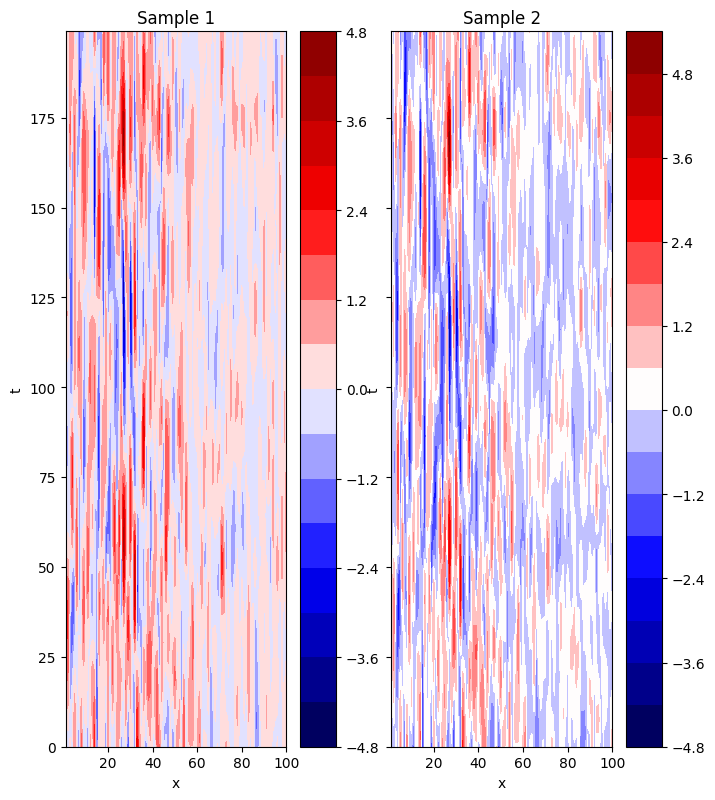

In [ ]:
compare_plot(KS_op.eval(KS_data_test[0:200]),KS_derivative_data_test[0:200])

# Train Dataset

In [ ]:
right_operator = ClassWrapper(KS_op)
solver = LSODA(right_operator)

initial_time = time.time()
estimated_field_train = solver.run(KS_data_train[0], t_data_train[0:1000])
elapsed_time = time.time() - initial_time
print(f"Elapsed time for time-integrating: {elapsed_time} s")

Elapsed time for time-integrating: 1.9412829875946045 s


In [ ]:
# Returning to 512 dimensions

reconstructed_data_train = pipeline.reconstruct_data(data=estimated_field_train)
data_train = pipeline.reconstruct_data(data=KS_data_train)


Applying the global reconstruction strategy.
Applying the global reconstruction strategy.


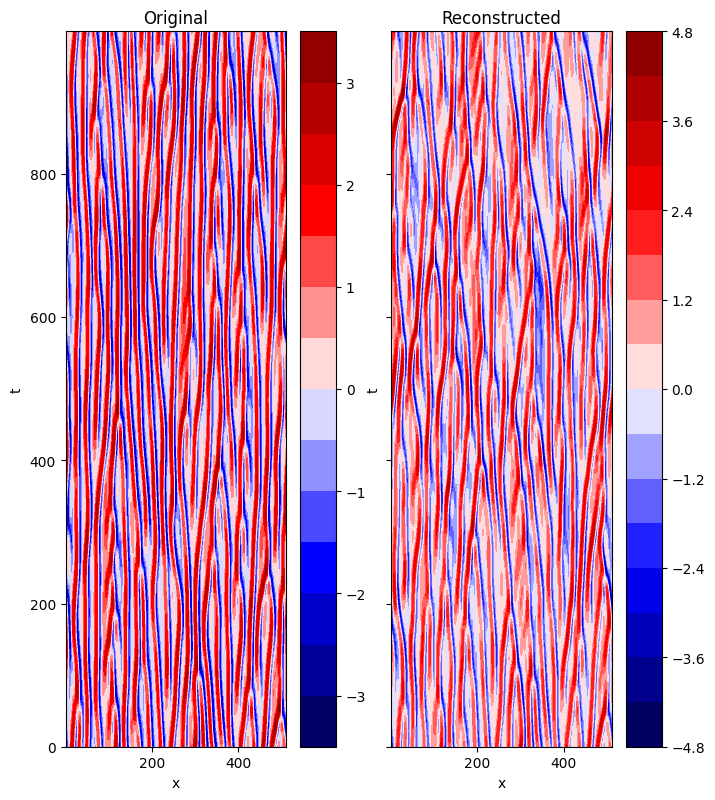

In [ ]:
# Comparing the results

compare_plot(data_train[0:1000], reconstructed_data_train[0:1000],"Original", "Reconstructed")

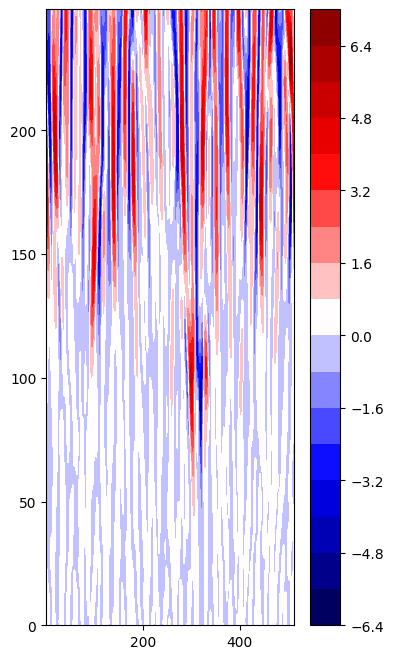

In [ ]:
#plotting the difference between the data

plot(data_train[0:250]-reconstructed_data_train[0:250])

## "View" along time

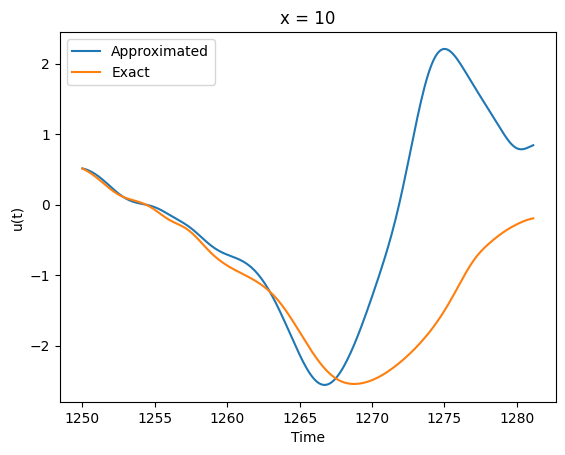

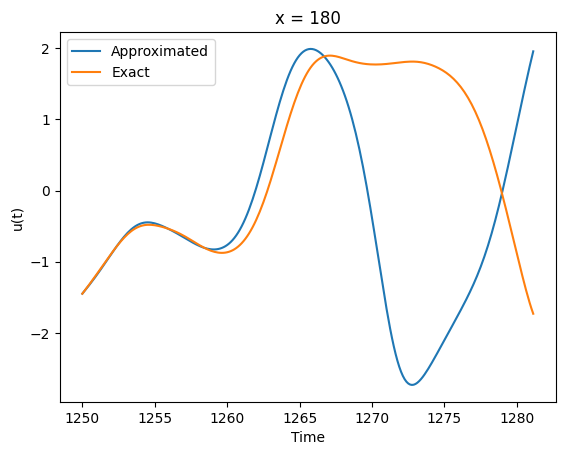

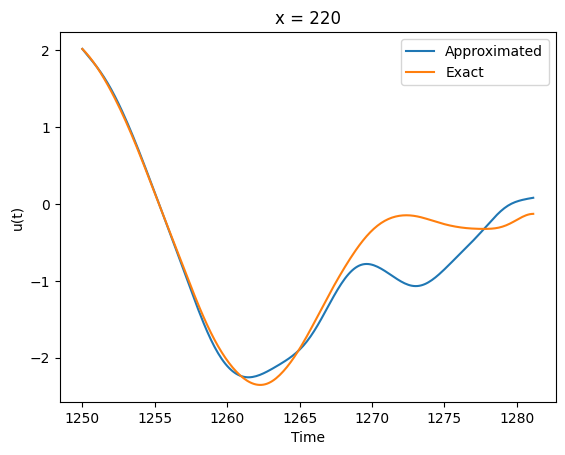

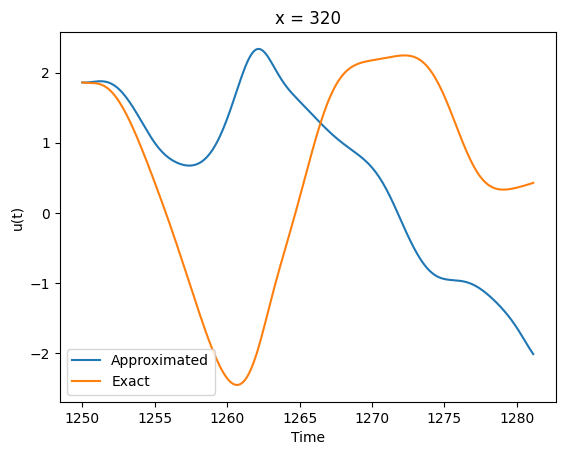

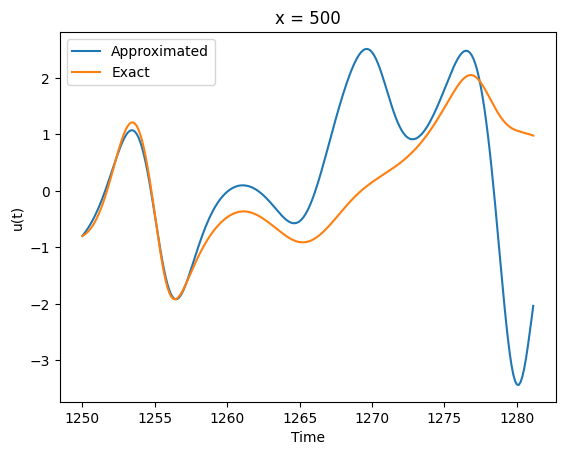

In [ ]:
start = 0
end = 250

samples = [10, 180, 220, 320, 500 ] # x values

for sample in samples:

  time_ref = t_data_train[start:end]
  x = data_train[start:end][:,sample]
  x_aprox = reconstructed_data_train[start:end][:,sample]
  plt.plot(time_ref, x_aprox, label="Approximated")
  plt.plot(time_ref, x, label="Exact")
  plt.xlabel("Time")
  plt.ylabel("u(t)")
  plt.title("x = "+ str(sample))
  plt.legend()
  plt.show()

## "View" along space

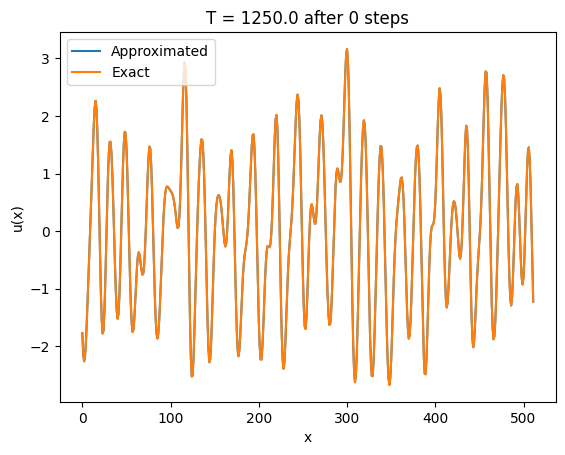

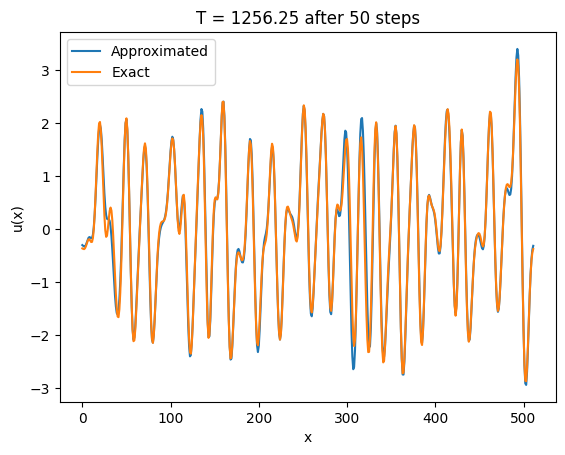

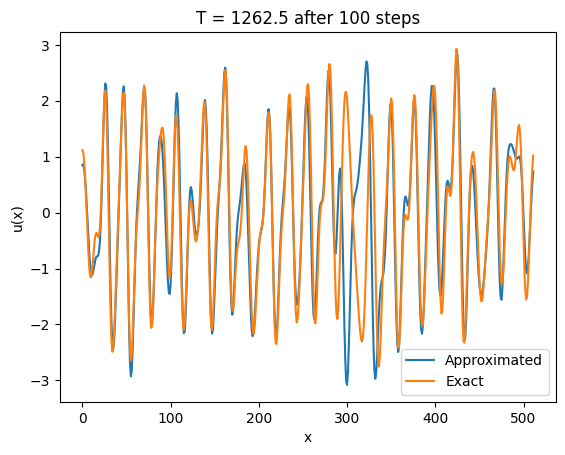

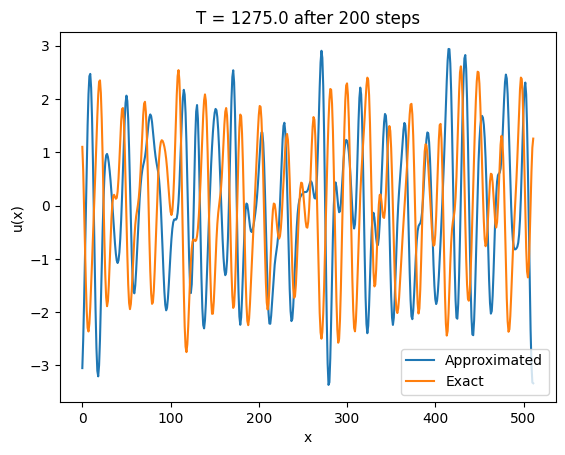

In [ ]:
samples = [0, 50, 100, 200] # t values


for sample in samples:

  x_ref = range(512)
  x = data_train[sample,:]
  x_aprox = reconstructed_data_train[sample,:]

  plt.plot(x_ref, x_aprox, label="Approximated")
  plt.plot(x_ref, x, label="Exact")
  plt.xlabel("x")
  plt.ylabel("u(x)" )
  plt.legend()
  plt.title("T = " + str(t_data_train[sample]) +" after " + str(sample) + " steps"  )
  plt.show()

# Test Dataset

In [ ]:
right_operator = ClassWrapper(KS_op)
solver = LSODA(right_operator)

initial_time = time.time()
estimated_field_test = solver.run(KS_data_train[-1], t_data_test[0:1000])
elapsed_time = time.time() - initial_time
print(f"Elapsed time for time-integrating: {elapsed_time} s")

Elapsed time for time-integrating: 1.189270257949829 s


In [ ]:
# Returning to 512 dimensions

reconstructed_data_test = pipeline.reconstruct_data(data=estimated_field_test)
data_test = pipeline.reconstruct_data(data=KS_data_test)


Applying the global reconstruction strategy.
Applying the global reconstruction strategy.


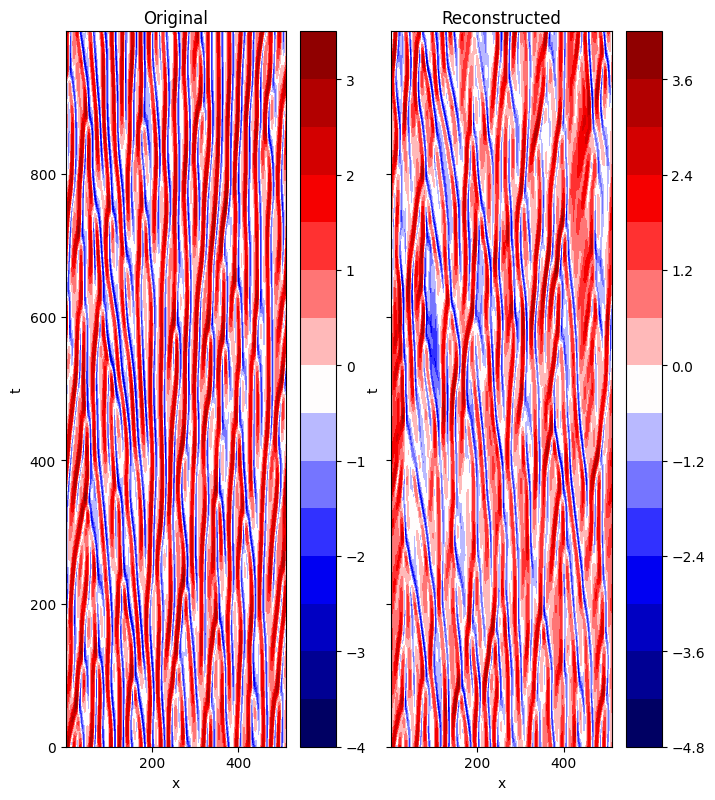

In [ ]:
# Comparing the results

compare_plot(data_test[0:1000], reconstructed_data_test[0:1000],"Original", "Reconstructed")

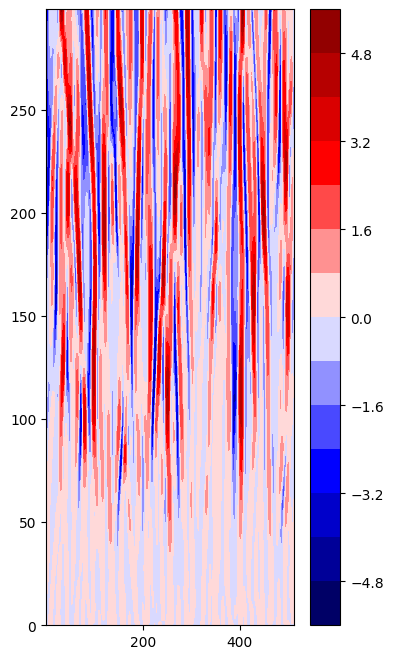

In [ ]:
#plotting the difference between the data

plot(data_test[0:300]-reconstructed_data_test[0:300])

## "View" along time

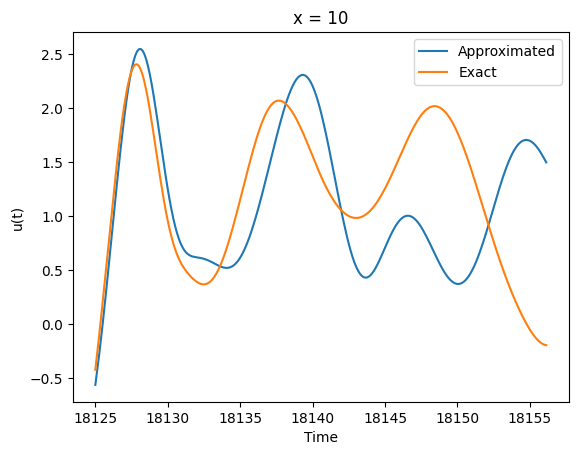

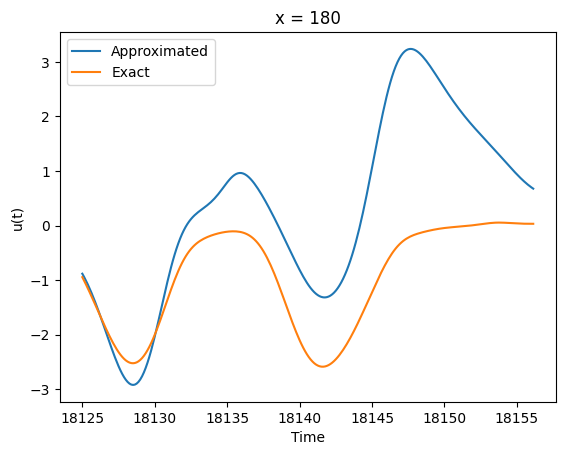

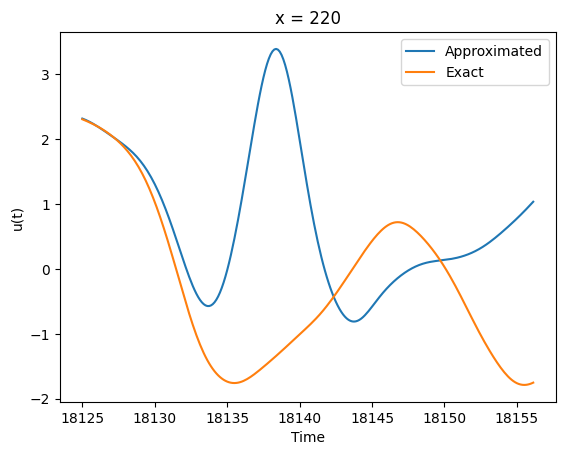

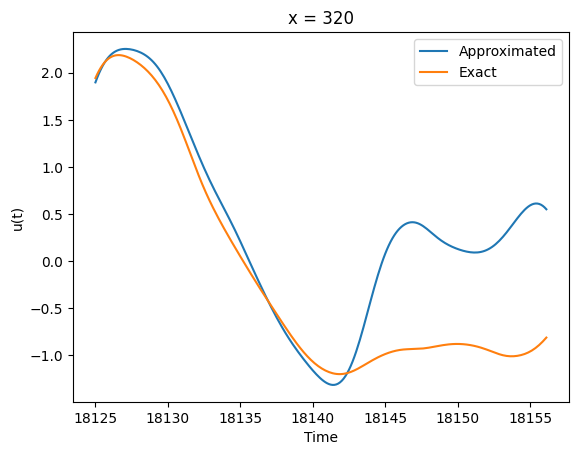

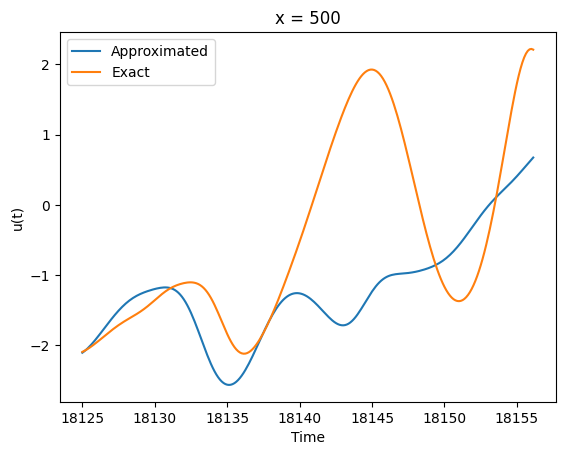

In [ ]:
start = 0
end = 250

samples = [10, 180, 220, 320, 500 ] # x values

for sample in samples:

  time_ref = t_data_test[start:end]
  x = data_test[start:end][:,sample]
  x_aprox = reconstructed_data_test[start:end][:,sample]
  plt.plot(time_ref, x_aprox, label="Approximated")
  plt.plot(time_ref, x, label="Exact")
  plt.xlabel("Time")
  plt.ylabel("u(t)")
  plt.title("x = "+ str(sample))
  plt.legend()
  plt.show()

## "View" along space

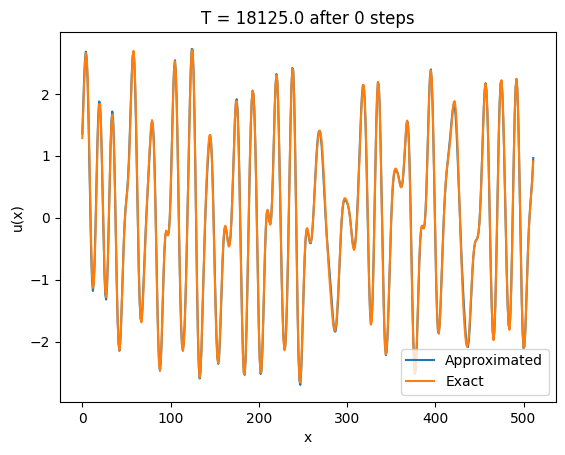

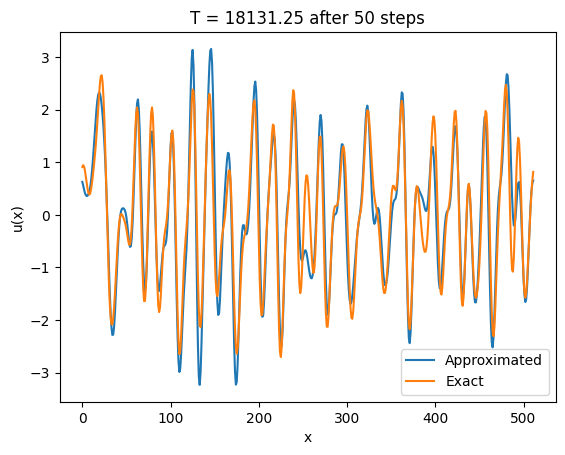

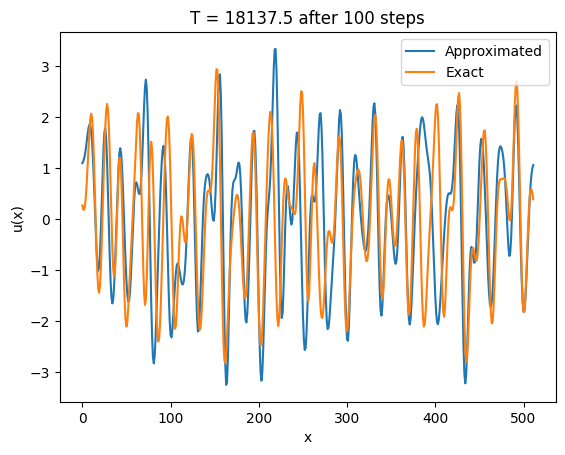

In [ ]:
samples = [0, 50, 100] # t values

for sample in samples:

  x_ref = range(512)
  x = data_test[sample,:]
  x_aprox = reconstructed_data_test[sample,:]

  plt.plot(x_ref, x_aprox, label="Approximated")
  plt.plot(x_ref, x, label="Exact")
  plt.xlabel("x")
  plt.ylabel("u(x)" )
  plt.legend()
  plt.title("T = " + str(t_data_test[sample])+" after " + str(sample) + " steps"  ) 
  plt.show()

# Conclusion

The results of this work for solving the Kuramoto-Sivashinsky problem were obtained by decomposing the initial dataset from 480000, to 150000 samples. Using 90% of the 150000 samples for training, and 10% for testing. The lambdas were chosen by error analysis. Better results can be obtained using the full dataset, which in this case was not used to minimize computational usage.